# Dataset Exploration
Having isolatad the CLIP image encoder and the brain encoder...

1. Calculate image and brain embeddings for the dataset
1. Run PCA on the embeddings

## What I understood from the code

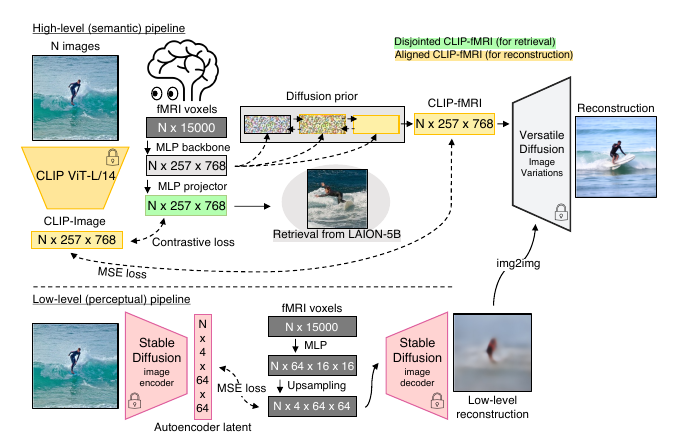

- I'll restrict myself to subject 1
    - Scotti et al only trained on 1, 2, 5, and 7 (the ones with data across all sessions)
    - They used the 1k shared images as test set
    - 2770 test samples were averaged over the 3 repetitions, resulting on 982 test samples
    - They refer to the test set as val, apparently. Did they use it for validation during training?
- I need to work with embeddings shaped $257\times 768$
    - Picked by Scotti et al to match the size at the last hidden layer of CLIP ViT/L-14
    - They should look like pictures. I'd love to plot them.
- I assume `Clipper` is the OpenAI CLIP encoder: 
    - For pre-trained models, it loads OpenAI's `"ViT-L/14"`
- I assume `OpenClipper` is the OpenCLIP encoder
    - It says `"THIS IS NOT WORKING CURRENTLY!"` on line 156, so maybe it's not fully functional x'D

## Global definitions

### Imports

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import datasets, decomposition
import torch
import torch.nn as nn
from tqdm import tqdm
import webdataset as wds

import pyvtools.dirs as dirs
import pyvtools.image as vim

import utils
from models import Clipper, BrainNetwork
import my_utils as mutils

%load_ext autoreload
%autoreload 2

<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.Tensor size changed, may indicate binary incompatibility. Expected 64 from C header, got 80 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.NativeFile size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.BufferedInputStream size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.BufferedOutputStream size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.CompressedInputStream size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.CompressedOutputStream size changed, may i

### Parameters

In [2]:
# Individual in the 1 to 8 range
subj = 1 

# Voxels per individual, sorted from Nr 1 to Nr 8
voxels_per_individual = [15724, 14278, 15226, 13153, 13039, 17907, 12682, 14386]
voxels_key = 'nsdgeneral.npy' # 1d inputs

# Path to where NSD data is stored
# data_path = "/fsx/proj-medarc/fmri/natural-scenes-dataset"
data_path = dirs.DATA_HOME
# Code is supposed to download dataset, if it's not found in there

# Path to metadata for all subjects
metadir = data_path

# Path to where the models are stored
# outdir = f'../train_logs/{autoencoder_name}'
outdir = dirs.MODELS_HOME

# Name of 257x768 model, used for everything except LAION-5B retrieval
model_name = "prior_257_final_subj01_bimixco_softclip_byol"

# Name of 1x768 model, used for LAION-5B retrieval
model_name2 = "prior_1x768_final_subj01_bimixco_softclip_byol"

# Name of the low-level pipeline's autoencoder
autoencoder_name = None

# Distribution factor between high and low-level pipelines
# 0 outputs the low-level image, 1 outputs the high-level image instead
img2img_strength = 1 # Not using img2img with the low-level pipeline on top of the high-level pipeline

# Network embedding parameters
out_dim = 257 * 768

# Retrieval test parameters
batch_size = 300 # same as used in mind_reader
test_batch_size = 300 # number of samples randomly picked (including the correct one) to assess accuracy
test_loops = 30 # number of times to go through the entire test set

# How many recons to output, to then automatically pick the best one (MindEye uses 16)
recons_per_sample = 1

### Definitions

In [3]:
num_voxels = voxels_per_individual[subj-1]
print("Subj", subj, "=> Num_voxels", num_voxels)

Subj 1 => Num_voxels 15724


In [4]:
train_url = f"{data_path}/train_subj0{subj}_" + "{0..17}.tar"
val_url = f"{data_path}/val_subj0{subj}_" + "{0..0}.tar"
# test_url = f"{data_path}/webdataset_avg_split/test/test_subj0{subj}_" + "{0..1}.tar"
test_url = f"{data_path}/test_subj0{subj}_" + "{0..1}.tar"
# meta_url = f"{data_path}/webdataset_avg_split/metadata_subj0{subj}.json"
meta_url = f"{data_path}/webdataset_avg_split_metadata_subj0{subj}.json"

In [5]:
metadata = json.load(open(meta_url))
num_train = metadata['totals']['train']
num_val = metadata['totals']['val']
num_test = metadata['totals']['test']

What is `num_train`? There are supposedly 24980 training samplesm not 8859. Mmm... It's close to 24980/3, but it's not exactly the same.

In [6]:
print(num_train*3)

25677


In [7]:
num_test

982

### General configuration

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Device: cuda


In [9]:
seed = 42 # Random seed picked in the original code
utils.seed_everything(seed=seed)

### Common neural networks

#### CLIP image encoder

In [10]:
clip_extractor = Clipper("ViT-L/14", hidden_state=True, norm_embs=True, device=device)

ViT-L/14 cuda


#### Brain encoder

In [11]:
voxel2clip_kwargs = dict(in_dim=num_voxels, out_dim=out_dim, use_projector=True, device=device)
voxel2clip = BrainNetwork(**voxel2clip_kwargs)
voxel2clip.requires_grad_(False)
voxel2clip.eval()

BrainNetwork(
  (lin0): Sequential(
    (0): Linear(in_features=15724, out_features=4096, bias=True)
    (1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
    (2): GELU(approximate='none')
    (3): Dropout(p=0.5, inplace=False)
  )
  (mlp): ModuleList(
    (0-3): 4 x Sequential(
      (0): Linear(in_features=4096, out_features=4096, bias=True)
      (1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
      (2): GELU(approximate='none')
      (3): Dropout(p=0.15, inplace=False)
    )
  )
  (lin1): Linear(in_features=4096, out_features=197376, bias=True)
  (projector): Sequential(
    (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=768, out_features=2048, bias=True)
    (3): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
    (4): GELU(approximate='none')
    (5): Linear(in_features=2048, out_features=2048, bias=True)
    (6): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
    (7): G

In [12]:
ckpt_path = os.path.join(outdir, model_name, f'voxel2clip.pth')
# ckpt_path = os.path.join(outdir, model_name, f'last.pth')

checkpoint = torch.load(ckpt_path, map_location=device)
state_dict = checkpoint['model']
# state_dict = checkpoint['model_state_dict']
print("Checkpoint's number of epochs: ", checkpoint['epoch'])

Checkpoint's number of epochs:  239


In [13]:
voxel2clip.load_state_dict(state_dict, strict=False)
voxel2clip.eval().to(device)
del state_dict, checkpoint

In [14]:
p = next(voxel2clip.named_parameters())
p

('lin0.0.weight',
 Parameter containing:
 tensor([[ 0.0651, -0.0193, -0.0110,  ..., -0.0751, -0.0496, -0.0234],
         [-0.0425, -0.0803, -0.0196,  ..., -0.0571, -0.0532, -0.0319],
         [ 0.0376, -0.0324,  0.0556,  ...,  0.0490, -0.0190, -0.0379],
         ...,
         [ 0.0506, -0.0744,  0.0136,  ..., -0.0337,  0.0480, -0.0220],
         [ 0.0130, -0.0304,  0.0146,  ...,  0.0096, -0.0330, -0.0138],
         [ 0.0131, -0.0220, -0.0389,  ...,  0.0018,  0.0117, -0.0169]],
        device='cuda:0'))

## Datasets

### Test dataset

#### One by one

In [15]:
test_data = wds.WebDataset(test_url, shardshuffle=False)\
    .decode("torch")\
    .rename(images="jpg;png", voxels=voxels_key, trial="trial.npy", coco="coco73k.npy", reps="num_uniques.npy")\
    .to_tuple("voxels", "images", "coco")

test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

# Check that your data loader is working
for idx, (voxel, img_input, coco) in enumerate(test_dataloader):
    print("IDx", idx)
    print("Voxel shape", voxel.shape)
    print("Input image shape", img_input.shape)
    print("Coco IDX shape", coco.shape)
    break
# del idx, voxel, img_input, coco

IDx 0
Voxel shape torch.Size([1, 3, 15724])
Input image shape torch.Size([1, 3, 256, 256])
Coco IDX shape torch.Size([1, 1])


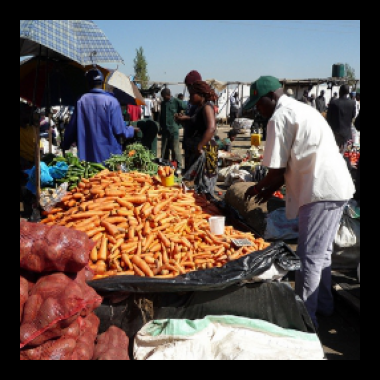

In [16]:
vim.plot_image(img_input[0].cpu().detach().numpy().transpose(1,2,0))

#### Three at a time

In [17]:
test_data = wds.WebDataset(test_url, shardshuffle=False)\
    .decode("torch")\
    .rename(images="jpg;png", voxels=voxels_key, trial="trial.npy", coco="coco73k.npy", reps="num_uniques.npy")\
    .to_tuple("voxels", "images", "coco")

test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=3, shuffle=False)

# Check that your data loader is working
for idx, (voxel, img_input, coco) in enumerate(test_dataloader):
    print("IDx", idx)
    print("Voxel shape", voxel.shape)
    print("Input image shape", img_input.shape)
    print("Coco IDX shape", coco.shape)
    break
# del idx, voxel, img_input, coco

IDx 0
Voxel shape torch.Size([3, 3, 15724])
Input image shape torch.Size([3, 3, 256, 256])
Coco IDX shape torch.Size([3, 1])


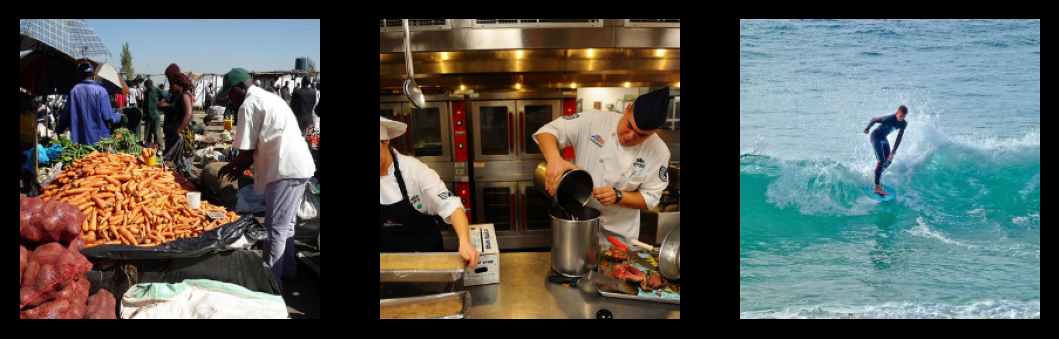

In [18]:
vim.plot_images(*img_input.cpu().detach().numpy().transpose(0,2,3,1))

#### Batches

In [19]:
test_data = wds.WebDataset(test_url, shardshuffle=False)\
    .decode("torch")\
    .rename(images="jpg;png", voxels=voxels_key, trial="trial.npy", coco="coco73k.npy", reps="num_uniques.npy")\
    .to_tuple("voxels", "images", "coco")\
    .batched(test_batch_size, partial=True)
    # .with_epoch(test_loops)

test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=None, shuffle=False)

# Check that your data loader is working
for idx, (voxel, img_input, coco) in enumerate(test_dataloader):
    print("IDx", idx)
    print("Voxel shape", voxel.shape)
    print("Image shape", img_input.shape)
    print("Coco IDX shape", coco.shape)
del idx, voxel, img_input, coco

IDx 0
Voxel shape torch.Size([300, 3, 15724])
Image shape torch.Size([300, 3, 256, 256])
Coco IDX shape torch.Size([300, 1])
IDx 1
Voxel shape torch.Size([300, 3, 15724])
Image shape torch.Size([300, 3, 256, 256])
Coco IDX shape torch.Size([300, 1])
IDx 2
Voxel shape torch.Size([300, 3, 15724])
Image shape torch.Size([300, 3, 256, 256])
Coco IDX shape torch.Size([300, 1])
IDx 3
Voxel shape torch.Size([82, 3, 15724])
Image shape torch.Size([82, 3, 256, 256])
Coco IDX shape torch.Size([82, 1])


### Training dataset

In [20]:
train_data = wds.WebDataset(train_url, shardshuffle=False)\
    .decode("torch")\
    .rename(images="jpg;png", voxels=voxels_key, trial="trial.npy", coco="coco73k.npy", reps="num_uniques.npy")\
    .to_tuple("voxels", "images", "coco")\
    .batched(test_batch_size, partial=True)
    # .with_epoch(test_loops)

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=None, shuffle=False)

# Check that your data loader is working
for idx, (voxel, img_input, coco) in enumerate(train_dataloader):
    print("IDx", idx)
    print("Voxel shape", voxel.shape)
    print("Image shape", img_input.shape)
    print("Coco IDX shape", coco.shape)
    break
del idx, voxel, img_input, coco

IDx 0
Voxel shape torch.Size([300, 3, 15724])
Image shape torch.Size([300, 3, 256, 256])
Coco IDX shape torch.Size([300, 1])


### Validation dataset

In [21]:
val_data = wds.WebDataset(val_url, shardshuffle=False)\
    .decode("torch")\
    .rename(images="jpg;png", voxels=voxels_key, trial="trial.npy", coco="coco73k.npy", reps="num_uniques.npy")\
    .to_tuple("voxels", "images", "coco")\
    .batched(test_batch_size, partial=True)
    # .with_epoch(test_loops)

val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=None, shuffle=False)

# Check that your data loader is working
for idx, (voxel, img_input, coco) in enumerate(val_dataloader):
    print("IDx", idx)
    print("Voxel shape", voxel.shape)
    print("Image shape", img_input.shape)
    print("Coco IDX shape", coco.shape)
    break
del idx, voxel, img_input, coco

IDx 0
Voxel shape torch.Size([300, 3, 15724])
Image shape torch.Size([300, 3, 256, 256])
Coco IDX shape torch.Size([300, 1])


## Embeddings

0it [00:00, ?it/s]

Voxel's shape torch.Size([300, 3, 15724])
Image's shape torch.Size([300, 3, 256, 256])
Averaged voxel's shape torch.Size([300, 15724])
Image embedding's shape torch.Size([300, 257, 768])
Brain embedding's shape torch.Size([300, 257, 768])


/home/vale/anaconda3/envs/mindeye/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
29it [02:55,  6.06s/it]
0it [00:00, ?it/s]

Voxel's shape torch.Size([300, 3, 15724])
Image's shape torch.Size([300, 3, 256, 256])
Averaged voxel's shape torch.Size([300, 15724])
Image embedding's shape torch.Size([300, 257, 768])
Brain embedding's shape torch.Size([300, 257, 768])


1it [00:06,  6.25s/it]
0it [00:00, ?it/s]

Voxel's shape torch.Size([300, 3, 15724])
Image's shape torch.Size([300, 3, 256, 256])
Averaged voxel's shape torch.Size([300, 15724])
Image embedding's shape torch.Size([300, 257, 768])
Brain embedding's shape torch.Size([300, 257, 768])


4it [00:20,  5.10s/it]


All image embedding's shape (9841, 197376)
All brain embedding's shape (9841, 197376)


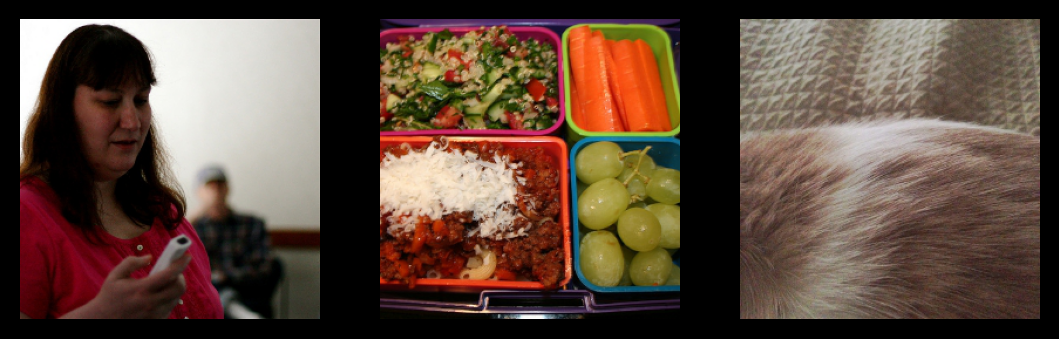

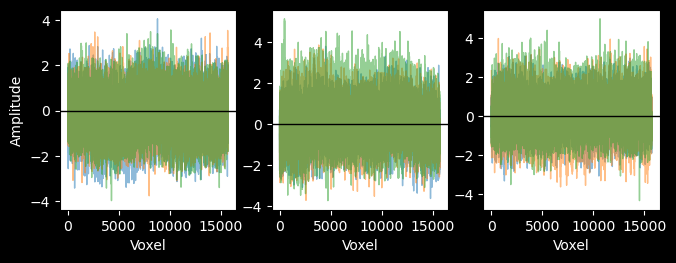

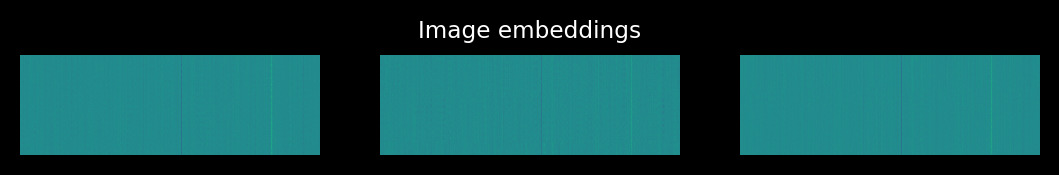

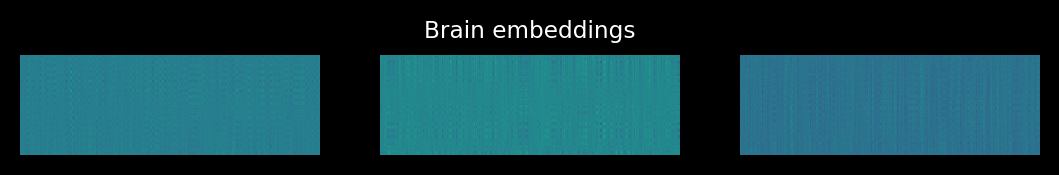

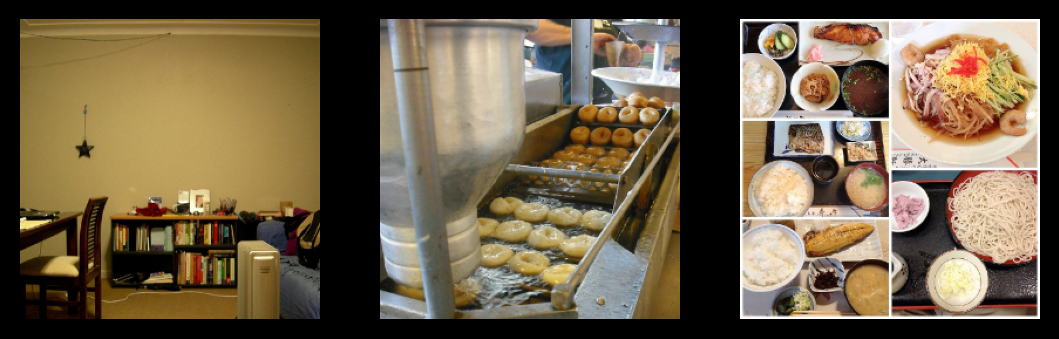

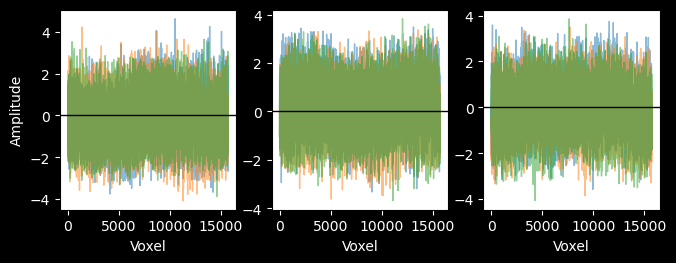

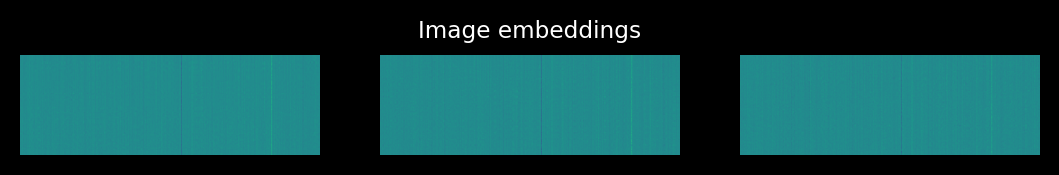

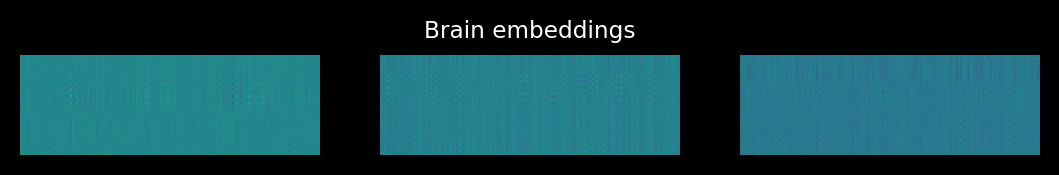

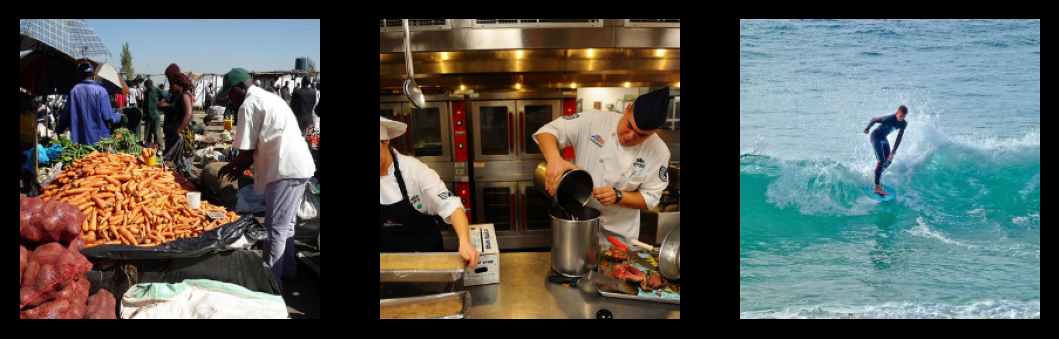

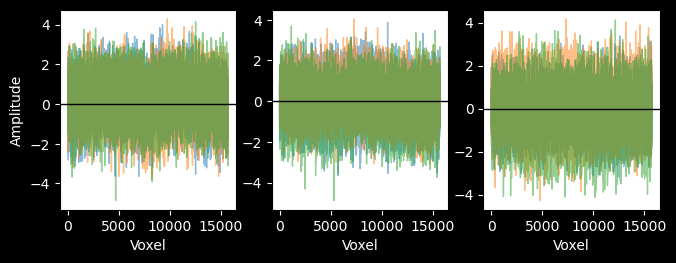

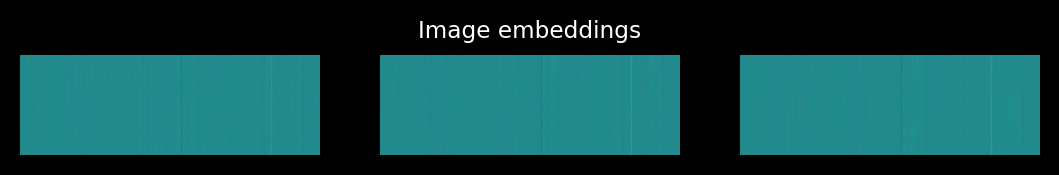

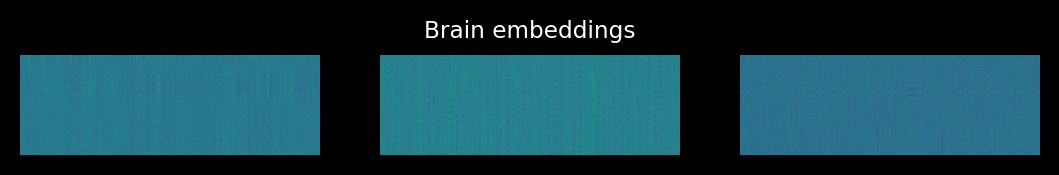

In [23]:
img_embeddings, brain_embeddings = [], []

with torch.no_grad():
    for dloader in (train_dataloader, val_dataloader, test_dataloader):
        k = 0
        for idx, (voxel, img, coco) in enumerate(tqdm(dloader)):

            if idx==0:
                print("Voxel's shape", voxel.shape)
                print("Image's shape", img.shape)
                vim.plot_images(*img[:3].cpu().detach().numpy().transpose(0,2,3,1))
                mutils.plot_brain_signals(*voxel.cpu().detach().numpy()[:3])

            voxel = torch.mean(voxel, axis=1).to(device) # average across repetitions
            # voxel = voxel[:,np.random.randint(3)].to(device) # random one of the single-trial samples

            emb_img = clip_extractor.embed_image(img.to(device)).float() # CLIP-Image
            
            _, emb_brain = voxel2clip(voxel.float()) # CLIP-Brain
            
            if idx==0:
                print("Averaged voxel's shape", voxel.shape)
                print("Image embedding's shape", emb_img.shape)
                print("Brain embedding's shape", emb_brain.shape)
                vim.plot_images(*emb_img[:3].cpu().detach().numpy(), labels=["","Image embeddings",""])
                vim.plot_images(*emb_brain[:3].cpu().detach().numpy(), labels=["","Brain embeddings",""])
            
            # Flatten if necessary
            emb_img = emb_img.reshape(len(emb_img),-1)
            emb_brain = emb_brain.reshape(len(emb_brain),-1)
            
            # # L2 normalization
            # emb_img = nn.functional.normalize(emb_img, dim=-1)
            # emb_brain = nn.functional.normalize(emb_brain, dim=-1)
            
            img_embeddings += list(emb_img.cpu().detach().numpy())
            brain_embeddings += list(emb_brain.cpu().detach().numpy())
                
            k += 1
            # break

img_embeddings = np.array(img_embeddings)
brain_embeddings = np.array(brain_embeddings)
print("All image embedding's shape", img_embeddings.shape)
print("All brain embedding's shape", brain_embeddings.shape)

### Split into datasets

In [41]:
num_test + num_val + num_train == len(img_embeddings)

True

In [42]:
img_embeddings_train = img_embeddings[:num_train]
img_embeddings_val = img_embeddings[num_train:-num_test]
img_embeddings_test = img_embeddings[-num_test:]

brain_embeddings_train = brain_embeddings[:num_train]
brain_embeddings_val = brain_embeddings[num_train:-num_test]
brain_embeddings_test = brain_embeddings[-num_test:]

## Basic characterization of embeddings

In [ ]:
all_img_min, all_img_max = [], []
all_img_mean, all_img_sqs_mean = [], []
all_brain_min, all_brain_max = [], []
all_brain_mean, all_brain_sqs_mean = [], []

for index, (img_emb, brain_emb) in tqdm(enumerate(zip(img_embeddings, brain_embeddings))):
    all_img_min.append(float(img_emb.min()))
    all_img_max.append(float(img_emb.max()))
    all_img_mean.append(np.mean(img_emb))
    all_img_sqs_mean.append(np.mean(img_emb**2))
    all_brain_min.append(float(brain_emb.min()))
    all_brain_max.append(float(brain_emb.max()))
    all_brain_mean.append(np.mean(brain_emb))
    all_brain_sqs_mean.append(np.mean(brain_emb**2))
del img_emb, brain_emb

all_img_min = np.array(all_img_min)
all_img_max = np.array(all_img_max)
all_img_mean = np.array(all_img_mean)
all_img_stds = np.sqrt( np.array(all_img_sqs_mean) - all_img_mean**2 )
all_brain_min = np.array(all_brain_min)
all_brain_max = np.array(all_brain_max)
all_brain_mean = np.array(all_brain_mean)
all_brain_stds = np.sqrt( np.array(all_brain_sqs_mean) - all_brain_mean**2 )

img_min = np.min(all_img_min); img_max = np.max(all_img_max)
img_mean = np.mean(all_img_mean, axis=0)
img_std = np.sqrt( np.mean(all_img_sqs_mean, axis=0) - img_mean**2 )
brain_min = np.min(all_brain_min); brain_max = np.max(all_brain_max)
brain_mean = np.mean(all_brain_mean, axis=0)
brain_std = np.sqrt( np.mean(all_brain_sqs_mean, axis=0) - brain_mean**2 )

9841it [00:02, 4811.54it/s]


In [44]:
all_img_min_train = all_img_min[:num_train]
all_img_max_train = all_img_max[:num_train]
all_img_mean_train = all_img_mean[:num_train]
all_img_stds_train = all_img_stds[:num_train]
all_img_sqs_mean_train = all_img_sqs_mean[:num_train]
all_brain_min_train = all_brain_min[:num_train]
all_brain_max_train = all_brain_max[:num_train]
all_brain_mean_train = all_brain_mean[:num_train]
all_brain_stds_train = all_brain_stds[:num_train]
all_brain_sqs_mean_train = all_brain_sqs_mean[:num_train]

all_img_min_val = all_img_min[num_train:-num_test]
all_img_max_val = all_img_max[num_train:-num_test]
all_img_mean_val = all_img_mean[num_train:-num_test]
all_img_stds_val = all_img_stds[num_train:-num_test]
all_img_sqs_mean_val = all_img_sqs_mean[num_train:-num_test]
all_brain_min_val = all_brain_min[num_train:-num_test]
all_brain_max_val = all_brain_max[num_train:-num_test]
all_brain_mean_val = all_brain_mean[num_train:-num_test]
all_brain_stds_val = all_brain_stds[num_train:-num_test]
all_brain_sqs_mean_val = all_brain_sqs_mean[num_train:-num_test]

all_img_min_test = all_img_min[-num_test:]
all_img_max_test = all_img_max[-num_test:]
all_img_mean_test = all_img_mean[-num_test:]
all_img_stds_test = all_img_stds[-num_test:]
all_img_sqs_mean_test = all_img_sqs_mean[-num_test:]
all_brain_min_test = all_brain_min[-num_test:]
all_brain_max_test = all_brain_max[-num_test:]
all_brain_mean_test = all_brain_mean[-num_test:]
all_brain_stds_test = all_brain_stds[-num_test:]
all_brain_sqs_mean_test = all_brain_sqs_mean[-num_test:]

In [46]:
img_min_train = np.min(all_img_min_train); img_max_train = np.max(all_img_max_train)
img_mean_train = np.mean(all_img_mean_train, axis=0)
img_std_train = np.sqrt( np.mean(all_img_sqs_mean_train, axis=0) - img_mean_train**2 )
brain_min_train = np.min(all_brain_min_train); brain_max_train = np.max(all_brain_max_train)
brain_mean_train = np.mean(all_brain_mean_train, axis=0)
brain_std_train = np.sqrt( np.mean(all_brain_sqs_mean_train, axis=0) - brain_mean_train**2 )

img_min_val = np.min(all_img_min_val); img_max_val = np.max(all_img_max_val)
img_mean_val = np.mean(all_img_mean_val, axis=0)
img_std_val = np.sqrt( np.mean(all_img_sqs_mean_val, axis=0) - img_mean_val**2 )
brain_min_val = np.min(all_brain_min_val); brain_max_val = np.max(all_brain_max_val)
brain_mean_val = np.mean(all_brain_mean_val, axis=0)
brain_std_val = np.sqrt( np.mean(all_brain_sqs_mean_val, axis=0) - brain_mean_val**2 )

img_min_test = np.min(all_img_min_test); img_max_test = np.max(all_img_max_test)
img_mean_test = np.mean(all_img_mean_test, axis=0)
img_std_test = np.sqrt( np.mean(all_img_sqs_mean_test, axis=0) - img_mean_test**2 )
brain_min_test = np.min(all_brain_min_test); brain_max_test = np.max(all_brain_max_test)
brain_mean_test = np.mean(all_brain_mean_test, axis=0)
brain_std_test = np.sqrt( np.mean(all_brain_sqs_mean_test, axis=0) - brain_mean_test**2 )

In [ ]:
print("Img Min & Max", (img_min, img_max))
print("Img Mean", img_mean)
print("Img Std", img_std)
print("Brain Min & Max", (brain_min, brain_max))
print("Brain Mean", brain_mean)
print("Brain Std", brain_std)

Img Min & Max (-0.5395607948303223, 0.5767476558685303)
Img Mean -0.00017259875
Img Std 0.02496349689814244
Brain Min & Max (-28.195886611938477, 36.74437713623047)
Brain Mean 0.0008686001
Brain Std 1.6008068878026984


In [47]:
print("Training Img Min & Max", (img_min_train, img_max_train))
print("Training Img Mean", img_mean_train)
print("Training Img Std", img_std_train)
print("Training Brain Min & Max", (brain_min_train, brain_max_train))
print("Training Brain Mean", brain_mean_train)
print("Training Brain Std", brain_std_train)

Training Img Min & Max (-0.5395607948303223, 0.5767476558685303)
Training Img Mean -0.00017294992
Training Img Std 0.02499514137835733
Training Brain Min & Max (-28.195886611938477, 36.74437713623047)
Training Brain Mean 0.00066467724
Training Brain Std 1.6007110674875


Warning! Training's and whole dataset's brain signals mean differ considerably

## Principal Components Analysis (PCA)

I'm worried that I needed to have a dataset with mean zero to start with. Luckily, the mean is close to 0. But is it enough?

Ah, no, PCA maximizes the variance of the compressed data, and the variance doesn't depend on the mean of the data ==> Everything should be alright.

### Training Principal Components

#### Normalize after running

In [90]:
img_pca = decomposition.PCA(n_components=2)
img_pca.fit(img_embeddings_train)

img_pca_data = img_pca.transform(img_embeddings_train)
print("Image data PCA shape", img_pca_data.shape)

Image data PCA shape (8559, 2)


In [91]:
brain_pca = decomposition.PCA(n_components=2)
brain_pca.fit(brain_embeddings_train)

brain_pca_data = brain_pca.transform(brain_embeddings_train)
print("Brain data PCA shape", brain_pca_data.shape)

Brain data PCA shape (8559, 2)


In [92]:
img_pca_data_norm = img_pca_data.T / np.mean(np.linalg.norm(img_pca_data, axis=1))
brain_pca_data_norm = brain_pca_data.T / np.mean(np.linalg.norm(brain_pca_data, axis=1))

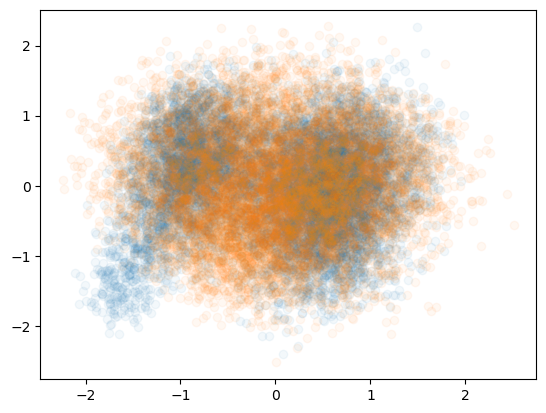

In [93]:
plt.scatter(*img_pca_data_norm, alpha=.05)
plt.scatter(*brain_pca_data_norm, alpha=.05)

#### Normalize before running

In [94]:
img_embeddings_norm = img_embeddings_train / np.mean(np.linalg.norm(img_embeddings_train, axis=1))
brain_embeddings_norm = brain_embeddings_train / np.mean(np.linalg.norm(brain_embeddings_train, axis=1))

In [95]:
img_pca = decomposition.PCA(n_components=2)
img_pca.fit(img_embeddings_norm)

img_pca_data = img_pca.transform(img_embeddings_norm)
print("Image data PCA shape", img_pca_data.shape)

Image data PCA shape (8559, 2)


In [96]:
brain_pca = decomposition.PCA(n_components=2)
brain_pca.fit(brain_embeddings_norm)

brain_pca_data = brain_pca.transform(brain_embeddings_norm)
print("Brain data PCA shape", brain_pca_data.shape)

Brain data PCA shape (8559, 2)


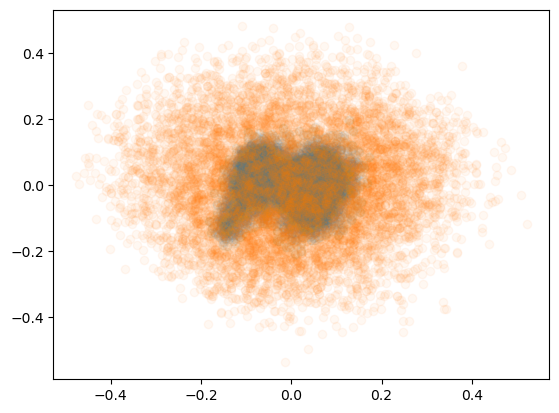

In [98]:
plt.scatter(*img_pca_data.T, alpha=.05)
plt.scatter(*brain_pca_data.T, alpha=.05)

### Validation Principal Components

#### Normalize after running

In [69]:
img_pca = decomposition.PCA(n_components=2)
img_pca.fit(img_embeddings_val)

img_pca_data = img_pca.transform(img_embeddings_val)
print("Image data PCA shape", img_pca_data.shape)

Image data PCA shape (300, 2)


In [70]:
brain_pca = decomposition.PCA(n_components=2)
brain_pca.fit(brain_embeddings_val)

brain_pca_data = brain_pca.transform(brain_embeddings_val)
print("Brain data PCA shape", brain_pca_data.shape)

Brain data PCA shape (300, 2)


In [71]:
img_pca_data_norm = img_pca_data.T / np.mean(np.linalg.norm(img_pca_data, axis=1))
brain_pca_data_norm = brain_pca_data.T / np.mean(np.linalg.norm(brain_pca_data, axis=1))

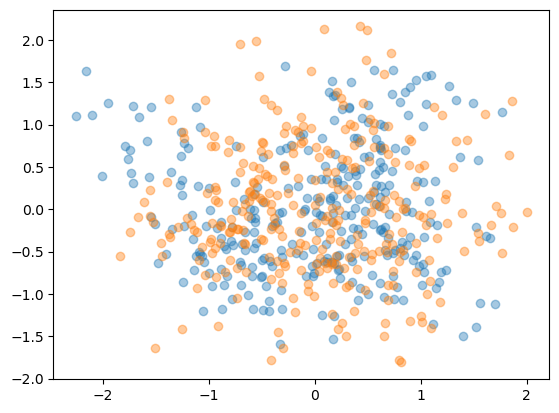

In [73]:
plt.scatter(*img_pca_data_norm, alpha=.4)
plt.scatter(*brain_pca_data_norm, alpha=.4)

#### Normalize before running

In [74]:
img_embeddings_norm = img_embeddings_val / np.mean(np.linalg.norm(img_embeddings_val, axis=1))
brain_embeddings_norm = brain_embeddings_val / np.mean(np.linalg.norm(brain_embeddings_val, axis=1))

In [75]:
img_pca = decomposition.PCA(n_components=2)
img_pca.fit(img_embeddings_norm)

img_pca_data = img_pca.transform(img_embeddings_norm)
print("Image data PCA shape", img_pca_data.shape)

Image data PCA shape (300, 2)


In [76]:
brain_pca = decomposition.PCA(n_components=2)
brain_pca.fit(brain_embeddings_norm)

brain_pca_data = brain_pca.transform(brain_embeddings_norm)
print("Brain data PCA shape", brain_pca_data.shape)

Brain data PCA shape (300, 2)


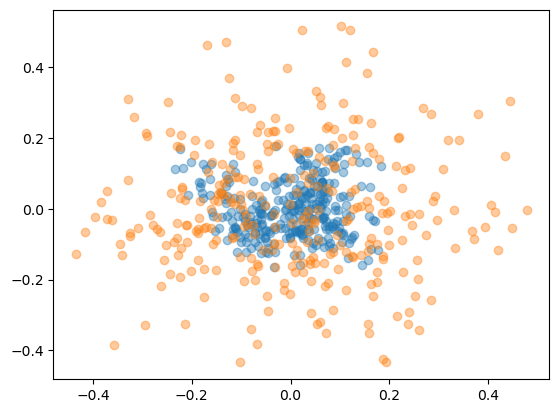

In [78]:
plt.scatter(*img_pca_data.T, alpha=.4)
plt.scatter(*brain_pca_data.T, alpha=.4)

### Test Principal Components

#### Normalize after running

In [99]:
img_pca = decomposition.PCA(n_components=2)
img_pca.fit(img_embeddings_test)

img_pca_data = img_pca.transform(img_embeddings_test)
print("Image data PCA shape", img_pca_data.shape)

Image data PCA shape (982, 2)


In [100]:
brain_pca = decomposition.PCA(n_components=2)
brain_pca.fit(brain_embeddings_test)

brain_pca_data = brain_pca.transform(brain_embeddings_test)
print("Brain data PCA shape", brain_pca_data.shape)

Brain data PCA shape (982, 2)


In [101]:
img_pca_data_norm = img_pca_data.T / np.mean(np.linalg.norm(img_pca_data, axis=1))
brain_pca_data_norm = brain_pca_data.T / np.mean(np.linalg.norm(brain_pca_data, axis=1))

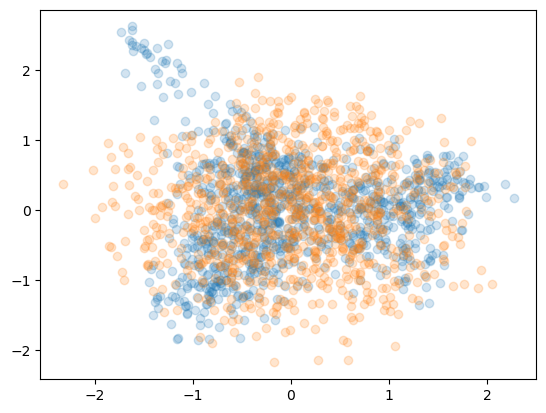

In [104]:
plt.scatter(*img_pca_data_norm, alpha=.2)
plt.scatter(*brain_pca_data_norm, alpha=.2)

#### Normalize before running

In [105]:
img_embeddings_norm = img_embeddings_test / np.mean(np.linalg.norm(img_embeddings_test, axis=1))
brain_embeddings_norm = brain_embeddings_test / np.mean(np.linalg.norm(brain_embeddings_test, axis=1))

In [106]:
img_pca = decomposition.PCA(n_components=2)
img_pca.fit(img_embeddings_norm)

img_pca_data = img_pca.transform(img_embeddings_norm)
print("Image data PCA shape", img_pca_data.shape)

Image data PCA shape (982, 2)


In [107]:
brain_pca = decomposition.PCA(n_components=2)
brain_pca.fit(brain_embeddings_norm)

brain_pca_data = brain_pca.transform(brain_embeddings_norm)
print("Brain data PCA shape", brain_pca_data.shape)

Brain data PCA shape (982, 2)


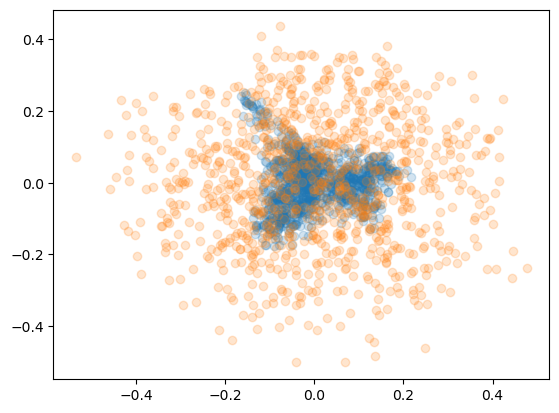

In [109]:
plt.scatter(*img_pca_data.T, alpha=.2)
plt.scatter(*brain_pca_data.T, alpha=.2)

### Validation Principal Components

#### Normalize after running

In [ ]:
img_pca = decomposition.PCA(n_components=2)
img_pca.fit(img_embeddings_val)

img_pca_data = img_pca.transform(img_embeddings_val)
print("Image data PCA shape", img_pca_data.shape)

Image data PCA shape (300, 2)


In [ ]:
brain_pca = decomposition.PCA(n_components=2)
brain_pca.fit(brain_embeddings_val)

brain_pca_data = brain_pca.transform(brain_embeddings_val)
print("Brain data PCA shape", brain_pca_data.shape)

Brain data PCA shape (300, 2)


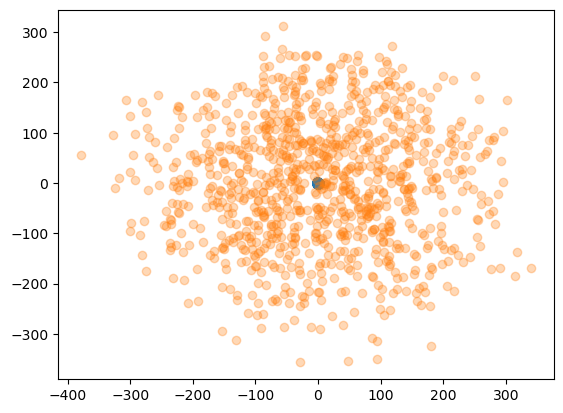

In [ ]:
plt.scatter(*img_pca_data.T, alpha=.3)
plt.scatter(*brain_pca_data.T, alpha=.3)

In [ ]:
img_pca_data_norm = img_pca_data.T / np.mean(np.linalg.norm(img_pca_data, axis=1))
brain_pca_data_norm = brain_pca_data.T / np.mean(np.linalg.norm(brain_pca_data, axis=1))

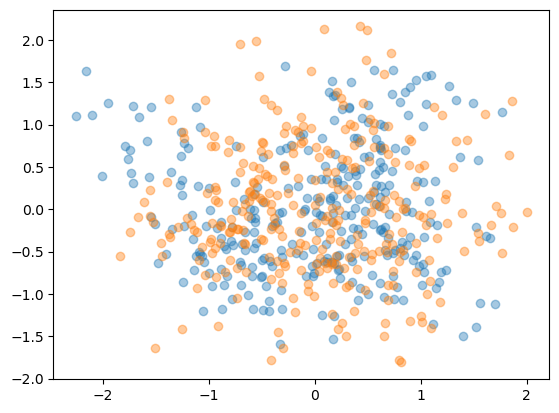

In [ ]:
plt.scatter(*img_pca_data_norm, alpha=.4)
plt.scatter(*brain_pca_data_norm, alpha=.4)

#### Normalize before running

In [ ]:
img_embeddings_norm = img_embeddings_val / np.mean(np.linalg.norm(img_embeddings_val, axis=1))
brain_embeddings_norm = brain_embeddings_val / np.mean(np.linalg.norm(brain_embeddings_val, axis=1))

In [ ]:
img_pca = decomposition.PCA(n_components=2)
img_pca.fit(img_embeddings_norm)

img_pca_data = img_pca.transform(img_embeddings_norm)
print("Image data PCA shape", img_pca_data.shape)

Image data PCA shape (300, 2)


In [ ]:
brain_pca = decomposition.PCA(n_components=2)
brain_pca.fit(brain_embeddings_norm)

brain_pca_data = brain_pca.transform(brain_embeddings_norm)
print("Brain data PCA shape", brain_pca_data.shape)

Brain data PCA shape (300, 2)


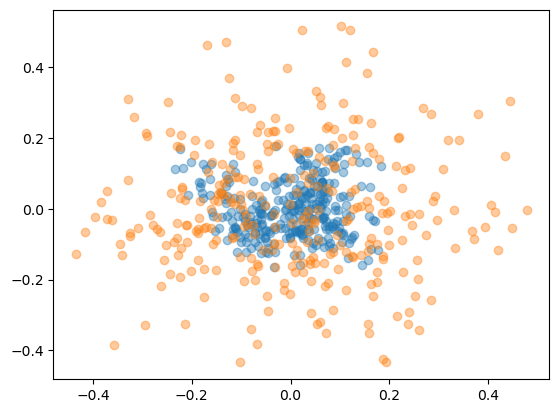

In [ ]:
plt.scatter(*img_pca_data.T, alpha=.4)
plt.scatter(*brain_pca_data.T, alpha=.4)

### Whole dataset

#### Normalize after running

In [79]:
img_pca = decomposition.PCA(n_components=2)
img_pca.fit(img_embeddings)

img_pca_data = img_pca.transform(img_embeddings)
print("Image data PCA shape", img_pca_data.shape)

Image data PCA shape (9841, 2)


In [80]:
brain_pca = decomposition.PCA(n_components=2)
brain_pca.fit(brain_embeddings)

brain_pca_data = brain_pca.transform(brain_embeddings)
print("Brain data PCA shape", brain_pca_data.shape)

Brain data PCA shape (9841, 2)


In [81]:
img_pca_data_norm = img_pca_data.T / np.mean(np.linalg.norm(img_pca_data, axis=1))
brain_pca_data_norm = brain_pca_data.T / np.mean(np.linalg.norm(brain_pca_data, axis=1))

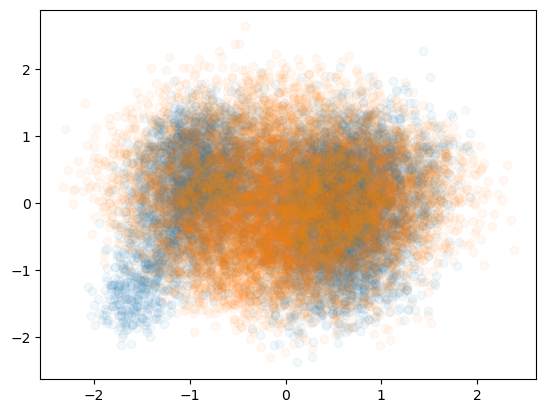

In [84]:
plt.scatter(*img_pca_data_norm, alpha=.05)
plt.scatter(*brain_pca_data_norm, alpha=.05)

#### Normalize before running

In [85]:
img_embeddings_norm = img_embeddings / np.mean(np.linalg.norm(img_embeddings, axis=1))
brain_embeddings_norm = brain_embeddings / np.mean(np.linalg.norm(brain_embeddings, axis=1))

In [86]:
img_pca = decomposition.PCA(n_components=2)
img_pca.fit(img_embeddings_norm)

img_pca_data = img_pca.transform(img_embeddings_norm)
print("Image data PCA shape", img_pca_data.shape)

Image data PCA shape (9841, 2)


In [87]:
brain_pca = decomposition.PCA(n_components=2)
brain_pca.fit(brain_embeddings_norm)

brain_pca_data = brain_pca.transform(brain_embeddings_norm)
print("Brain data PCA shape", brain_pca_data.shape)

Brain data PCA shape (9841, 2)


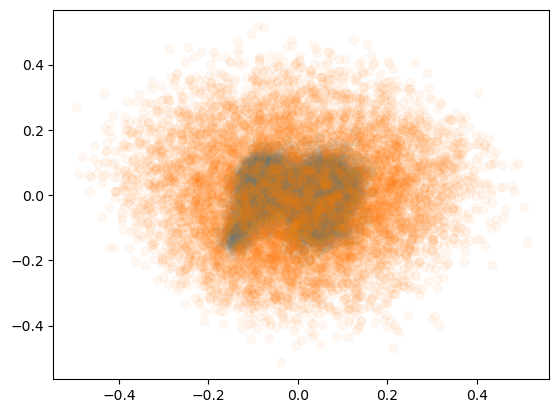

In [89]:
plt.scatter(*img_pca_data.T, alpha=.05)
plt.scatter(*brain_pca_data.T, alpha=.05)